In [38]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [39]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [40]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [61]:
# ase genes to remove
df = pd.read_csv('/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/08_allele_specifics/ase_results_threeannots.tsv', sep='\t')
df = df.loc[(df.annot=='PODER')&\
            (df.FDR<=0.05)]
df['gid'] = cerberus.get_stable_gid(df, 'geneid.v')
ase_gids = df.gid.tolist()

In [62]:
astu_df = pd.read_csv('/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/08_allele_specifics/ASTS_results_threeannots.tsv', sep='\t')
astu_df = astu_df.loc[(astu_df.annot=='PODER')&\
                      (astu_df.gene_testable==True)]
astu_df['gid'] = cerberus.get_stable_gid(astu_df, 'geneid.v')

In [63]:
# remove ase genes
print(len(astu_df.index))
astu_df = astu_df.loc[~(astu_df.gid.isin(ase_gids))]
print(len(astu_df.index))

47073
7055


In [64]:
# limit to astu gwas thing
df = pd.read_csv('/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/08_allele_specifics/ASTU_GWAS_PODER.tsv', sep='\t')
df.head()

# explode gene id
df['geneID'] = df.geneID.str.split('/')
df = df.explode('geneID')

print(len(astu_df.index))
astu_df = astu_df.loc[astu_df['gid'].isin(df.geneID.tolist())]
print(len(astu_df.index))

# add in trait
astu_df = astu_df.merge(df[['ID', 'geneID']],
                        how='left',
                        left_on='gid',
                        right_on='geneID')
# astu_df.head()

7055
422


In [65]:
# calculate the ratio
astu_df['ratio'] = (astu_df['refCount']+1)/(astu_df['altCount']+1)

# log ratio
astu_df['log_ratio'] = np.log(astu_df['ratio'])

In [66]:
# get the max difference of ratios for each gene in each sample
temp = astu_df[['log_ratio', 'gid', 'sample']].groupby(['gid', 'sample']).max().reset_index().rename({'log_ratio':'max_log_ratio'}, axis=1)
astu_df = astu_df.merge(temp, how='left', on=['sample', 'gid'])

temp = astu_df[['log_ratio', 'gid', 'sample']].groupby(['gid', 'sample']).min().reset_index().rename({'log_ratio':'min_log_ratio'}, axis=1)
astu_df = astu_df.merge(temp, how='left', on=['sample', 'gid'])

In [67]:
# only get ones with a pos and neg as min and max
print(len(astu_df.index))
astu_df = astu_df.loc[(astu_df.max_log_ratio>0)&\
                      (astu_df.min_log_ratio<0)]
print(len(astu_df.index))

2312
2035


In [68]:
astu_df['effect_size_maybe'] = astu_df['max_log_ratio']+\
                               np.abs(astu_df['min_log_ratio'])

2035
46


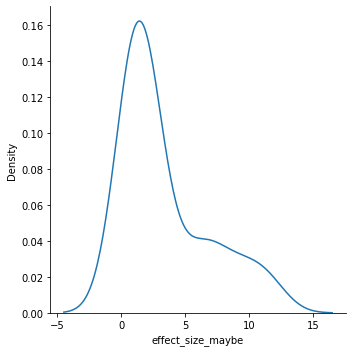

In [70]:
# plot distribution of "effect sizes"
print(len(astu_df.index))
temp = astu_df[['gid', 'effect_size_maybe']].drop_duplicates()
print(len(temp.index))

sns.displot(temp, x='effect_size_maybe', kind='kde')

In [71]:
astu_df.loc[astu_df.effect_size_maybe>7].sort_values(by='effect_size_maybe', ascending=False).head(30).tail(10)

,samplecode,sample,population,map_reads_assemblymap,gene_variant,statistic,p.value,FDR,geneid.v,transcriptid.v,...,gene_testable,annot,gid,ID,geneID,ratio,log_ratio,max_log_ratio,min_log_ratio,effect_size_maybe
2216,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345329,...,True,PODER,ENSG00000204525,Basal cell carcinoma,ENSG00000204525,1180.000000,7.073270,7.07327,-4.705427,11.778697
2217,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345329,...,True,PODER,ENSG00000204525,Hip circumference adjusted for BMI,ENSG00000204525,1180.000000,7.073270,7.07327,-4.705427,11.778697
2233,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345202,...,True,PODER,ENSG00000204525,Free cholesterol to total lipids ratio in larg...,ENSG00000204525,0.361702,-1.016934,7.07327,-4.705427,11.778697
2232,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345202,...,True,PODER,ENSG00000204525,Hypothyroidism or rheumatoid arthritis (pleiot...,ENSG00000204525,0.361702,-1.016934,7.07327,-4.705427,11.778697
2231,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345202,...,True,PODER,ENSG00000204525,Rheumatoid arthritis or type 1 diabetes,ENSG00000204525,0.361702,-1.016934,7.07327,-4.705427,11.778697
2230,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345292,...,True,PODER,ENSG00000204525,Takayasu arteritis,ENSG00000204525,0.272727,-1.299283,7.07327,-4.705427,11.778697
2228,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345292,...,True,PODER,ENSG00000204525,Rheumatoid arthritis or irritable bowel disease,ENSG00000204525,0.272727,-1.299283,7.07327,-4.705427,11.778697
2227,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345292,...,True,PODER,ENSG00000204525,Ratio of triglycerides to phosphoglycerides,ENSG00000204525,0.272727,-1.299283,7.07327,-4.705427,11.778697
2226,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345292,...,True,PODER,ENSG00000204525,Hip circumference adjusted for BMI,ENSG00000204525,0.272727,-1.299283,7.07327,-4.705427,11.778697
2225,45_EU5_GM12878,CEU5,CEU,19493442,ENSG00000204525.18:chr6_31268945_C_T,923.315353,0.0005,0.002006,ENSG00000204525.18,transcript_345292,...,True,PODER,ENSG00000204525,Basal cell carcinoma,ENSG00000204525,0.272727,-1.299283,7.07327,-4.705427,11.778697


In [73]:
astu_df.loc[astu_df.population=='YRI'].sort_values(by='effect_size_maybe', ascending=False)

,samplecode,sample,population,map_reads_assemblymap,gene_variant,statistic,p.value,FDR,geneid.v,transcriptid.v,...,gene_testable,annot,gid,ID,geneID,ratio,log_ratio,max_log_ratio,min_log_ratio,effect_size_maybe
192,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31272052_C_T,9.838004,0.035482,0.106246,ENSG00000204525.18,transcript_345329,...,True,PODER,ENSG00000204525,Triglycerides to total lipids ratio in very la...,ENSG00000204525,4.000000,1.386294,6.093570,-5.119191,11.212760
134,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269031_C_G,16.505464,0.006997,0.026461,ENSG00000204525.18,transcript_345329,...,True,PODER,ENSG00000204525,Basal cell carcinoma,ENSG00000204525,0.444444,-0.810930,6.093570,-5.119191,11.212760
125,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269031_C_G,16.505464,0.006997,0.026461,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Basal cell carcinoma,ENSG00000204525,0.038005,-3.270044,6.093570,-5.119191,11.212760
126,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269031_C_G,16.505464,0.006997,0.026461,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Hip circumference adjusted for BMI,ENSG00000204525,0.038005,-3.270044,6.093570,-5.119191,11.212760
127,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269031_C_G,16.505464,0.006997,0.026461,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Ratio of triglycerides to phosphoglycerides,ENSG00000204525,0.038005,-3.270044,6.093570,-5.119191,11.212760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,8_NI3_GM18906,YRI3,YRI,11948138,ENSG00000003056.8:chr12_8940405_G_A,1.287513,0.344828,0.546043,ENSG00000003056.8,transcript_236350,...,True,PODER,ENSG00000003056,Rheumatoid arthritis or type 1 diabetes,ENSG00000003056,1.500000,0.405465,0.405465,-0.177681,0.583146
283,11_NI6_GM19129,YRI6,YRI,9574709,ENSG00000072818.12:chr17_7336592_A_G,0.614035,0.524738,0.751787,ENSG00000072818.12,transcript_77998,...,True,PODER,ENSG00000072818,Systemic lupus erythematosus,ENSG00000072818,1.444444,0.367725,0.367725,-0.117783,0.485508
282,11_NI6_GM19129,YRI6,YRI,9574709,ENSG00000072818.12:chr17_7336592_A_G,0.614035,0.524738,0.751787,ENSG00000072818.12,transcript_78000,...,True,PODER,ENSG00000072818,Systemic lupus erythematosus,ENSG00000072818,0.888889,-0.117783,0.367725,-0.117783,0.485508
5,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000072818.12:chr17_7336592_A_G,0.229267,0.665667,0.843438,ENSG00000072818.12,transcript_77998,...,True,PODER,ENSG00000072818,Systemic lupus erythematosus,ENSG00000072818,1.045455,0.044452,0.044452,-0.162519,0.206971


In [77]:
astu_df.loc[(astu_df['geneID']=='ENSG00000204525')&\
            (astu_df['sample']=='YRI2')&\
            (astu_df['log_ratio']==astu_df['max_log_ratio'])]
            

,samplecode,sample,population,map_reads_assemblymap,gene_variant,statistic,p.value,FDR,geneid.v,transcriptid.v,...,gene_testable,annot,gid,ID,geneID,ratio,log_ratio,max_log_ratio,min_log_ratio,effect_size_maybe
158,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Rheumatoid arthritis or type 1 diabetes,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
159,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Hypothyroidism or rheumatoid arthritis (pleiot...,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
160,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Free cholesterol to total lipids ratio in larg...,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
161,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Basal cell carcinoma,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
162,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Hip circumference adjusted for BMI,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
163,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Ratio of triglycerides to phosphoglycerides,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
164,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Rheumatoid arthritis or irritable bowel disease,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
165,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Triglycerides to total lipids ratio in very la...,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276
166,7_NI2_GM18489,YRI2,YRI,18066961,ENSG00000204525.18:chr6_31269044_C_T,33.158026,0.029985,0.093176,ENSG00000204525.18,transcript_345336,...,True,PODER,ENSG00000204525,Takayasu arteritis,ENSG00000204525,443.0,6.09357,6.09357,-5.119191,11.21276


In [79]:
astu_df.loc[astu_df['transcriptid.v']=='transcript_345336'][['transcript_variant','refCount', 'altCount']]

,transcript_variant,refCount,altCount
32,transcript_345336:chr6_31268790_T_C,4,835
33,transcript_345336:chr6_31268790_T_C,4,835
34,transcript_345336:chr6_31268790_T_C,4,835
35,transcript_345336:chr6_31268790_T_C,4,835
36,transcript_345336:chr6_31268790_T_C,4,835
...,...,...,...
1990,transcript_345336:chr6_31269085_C_T,286,2
1991,transcript_345336:chr6_31269085_C_T,286,2
1992,transcript_345336:chr6_31269085_C_T,286,2
1993,transcript_345336:chr6_31269085_C_T,286,2


In [81]:
astu_df.loc[(astu_df['geneID']=='ENSG00000204525')&\
            (astu_df['sample']=='YRI2')&\
            (astu_df.log_ratio>0)]['transcriptid.v'].unique()

array(['transcript_345336', 'transcript_345291', 'transcript_345329'],
      dtype=object)

In [82]:
astu_df.loc[(astu_df['geneID']=='ENSG00000204525')&\
            (astu_df['sample']=='YRI2')&\
            (astu_df.log_ratio<0)]['transcriptid.v'].unique()

array(['transcript_345291', 'transcript_345329', 'transcript_345336'],
      dtype=object)

In [ ]:
ref_higher_tids = ['transcript_345336', 'transcript_345291', 'transcript_345329']
alt_higher_tids = ['transcript_345291', 'transcript_345329', 'transcript_345336']